In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

# Definitions

See 3.111 and 3.98 in http://theory.caltech.edu/~preskill/ph219/chap3_15.pdf 

Amplitude damping channel:
$$
K_0 = \begin{bmatrix} 1 & 0 \\ 0 & \sqrt{1-\gamma} \end{bmatrix} 
$$
$$
K_1 = \begin{bmatrix} 0 & \sqrt{\gamma} \\ 0 & 0 \end{bmatrix}.
$$

Dephasing channel 
\begin{aligned}
L_0 &= \sqrt{1-\kappa} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, \\
L_1 &= \sqrt{\kappa} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}, \\
L_2 &= \sqrt{\kappa} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}. \\
\end{aligned}

For convience in the state definition make the map 
$$
    \gamma \mapsto \frac{1}{1 + e^{-a} }
$$
and 

$$
    \kappa \mapsto \frac{1}{1 + e^{-b} }
$$

so that the Kraus operators become:
$$
K_0 = \begin{bmatrix} 1 & 0 \\ 0 & \sqrt{\frac{e^{-a}}{1+e^{-a}}} \end{bmatrix} 
$$
$$
K_1 = \begin{bmatrix} 0 & \sqrt{\frac{1}{1+e^{-a}}} \\ 0 & 0 \end{bmatrix}.
$$
and 
\begin{aligned}
L_0 &= \sqrt{\frac{e^{-b}}{1 + e^{-b}}} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, \\
L_1 &= \sqrt{\frac{1}{1 + e^{-b}}} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}, \\
L_2 &= \sqrt{\frac{1}{1 + e^{-b}}} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}. \\
\end{aligned}

Unitary
$$
    U(x) = \exp \left(- \frac{i}{2} \left(\frac{\pi}{2} + \phi\right) \mathbf{X} \right)
$$

The state is then 
$$
    x = (\phi, a, b)
$$
so that $(0, 0, 0)$ is the target state. 

The channel map is 
$$
   \mathcal{L} \circ \mathcal{K} \circ \mathcal{U} [\rho_0].
$$


However, I found that the dephasing channel is not estimatable, which makes sense actually. 


In [2]:
RHO_0 = np.array([1, 0, 0, 0])
M_0 = np.array([1, 0, 0, 0])
M_1 = np.array([0, 0, 0, 1])

def make_amp_decay_kraus_operators(a):
    r0 = np.sqrt(np.exp(-a) / (1 + np.exp(-a)))
    r1 = np.sqrt(1 / (1 + np.exp(-a)))
    K0 = np.array([[1, 0], [0, r0]])
    K1 = np.array([[0, r1], [0, 0]])
    return [K0, K1]

def make_dephasing_kraus_operators(b):
    r0 = np.sqrt(np.exp(-b) / (1 + np.exp(-b)))
    r1 = np.sqrt(1 / (1 + np.exp(-b)))
    L0 = r0*np.eye(2)
    L1 = r1*np.array([[1, 0], [0, 0]])
    L2 = r1*np.array([[0, 0], [0, 1]])
    return [L0, L1, L2]

def make_unitary(phi):
    return expm(-(1j/2)*(np.pi/2 + phi)*SigX)



def verify_kraus_rep(Ks):
    conjs= [K.conj().T@K for K in Ks]
    assert np.allclose(np.eye(2), sum([K.conj().T @ K for K in Ks])), print(sum(conjs))

verify_kraus_rep(make_dephasing_kraus_operators(1))
Ks = make_amp_decay_kraus_operators(1)
verify_kraus_rep([make_unitary(1)])

In [3]:
def kraus_to_superoperator(Ks):
    return np.sum([np.kron(K.conj(), K) for K in Ks], axis=0)

def unitary_to_superoperator(U):
    return np.kron(U.conj(), U)

def state_to_superoperator(x):
    phi, a, b = x
    U = make_unitary(phi)
    K_amp_damp = make_amp_decay_kraus_operators(a)
    K_deph = make_dephasing_kraus_operators(b)
    S_U = unitary_to_superoperator(U)
    S_K_amp_damp = kraus_to_superoperator(K_amp_damp)
    S_K_deph = kraus_to_superoperator(K_deph)
    return S_U @ S_K_amp_damp @ S_K_deph

In [4]:
def make_state_at_depth(x, d):
    rho = RHO_0.flatten()
    super_op_unitary = unitary_to_superoperator(make_unitary(x[0]))
    super_op_amp_decay = kraus_to_superoperator(make_amp_decay_kraus_operators(x[1]))
    #super_op_dephasing = kraus_to_superoperator(make_dephasing_kraus_operators(x[2]))
    super_op = super_op_amp_decay @ super_op_unitary
    super_op_power = np.linalg.matrix_power(super_op, d)
    rho_d = super_op_power @ rho
    return rho_d

def make_prob_at_depth(x, d):
    rho_d = make_state_at_depth(x, d)
    p0 = np.dot(M_0, rho_d)
    p1 = np.dot(M_1, rho_d)
    assert np.imag(p0) < 1e-10, f"p0 has imaginary part: {p0}"
    assert np.imag(p1) < 1e-10, f"p1 has imaginary part: {p1}"
    p0 = np.real(p0)
    p1 = np.real(p1)
    return np.array([p0, p1])

def sample_at_depth(x, d, n):
    probs = make_prob_at_depth(x, d)
    c0 = np.random.binomial(n, probs[0])
    c1 = n - c0
    return np.array([c0, c1])

In [74]:
def make_prob_series(x, depths):
    trajs = []
    for d in depths:
        trajs.append(make_prob_at_depth(x, d))
    return np.array(trajs).T

def make_sample_series(x, depths, n):
    trajs = []
    for d in depths:
        trajs.append(sample_at_depth(x, d, n))
    return np.array(trajs).T

def make_quadrature_prob_series(x, max_depth_power):
    in_phase_trajs = []
    out_of_phase_trajs = []
    depths_in_phase = [2**p for p in range(max_depth_power)]
    depths_out_of_phase = [2**p + 1 for p in range(max_depth_power)]
    for d in depths_in_phase:
        in_phase_trajs.append(make_prob_at_depth(x, d)[0])
    for d in depths_out_of_phase:
        out_of_phase_trajs.append(make_prob_at_depth(x, d)[0])
    return np.array([np.array(in_phase_trajs).T, np.array(out_of_phase_trajs).T])

def make_quadrature_sample_series(x, max_depth_power, n):
    in_phase_trajs = []
    out_of_phase_trajs = []
    depths_in_phase = [2**p for p in range(max_depth_power)]
    depths_out_of_phase = [2**p + 1 for p in range(max_depth_power)]
    for d in depths_in_phase:
        in_phase_trajs.append(sample_at_depth(x, d, n)[0])
    for d in depths_out_of_phase:
        out_of_phase_trajs.append(sample_at_depth(x, d, n)[0])
    return np.array([np.array(in_phase_trajs).T, np.array(out_of_phase_trajs).T])

In [75]:
def plot_series_array(series_array, labels=None):
    fig, axs = plt.subplots(len(series_array[0]), figsize=(10, 5))
    for i, traj in enumerate(series_array):
        for j, ax in enumerate(axs):
            ax.plot(traj[j], label=labels[i] if labels else None)
    plt.legend()
    plt.show()

def plot_quadrature_prob_series_array(series_array):
    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.plot(series_array[0], label="In phase")
    axs.plot(series_array[1], label="Out of phase")
    axs.set_title("Support on outcome 0")
    plt.legend()
    plt.tight_layout()
    

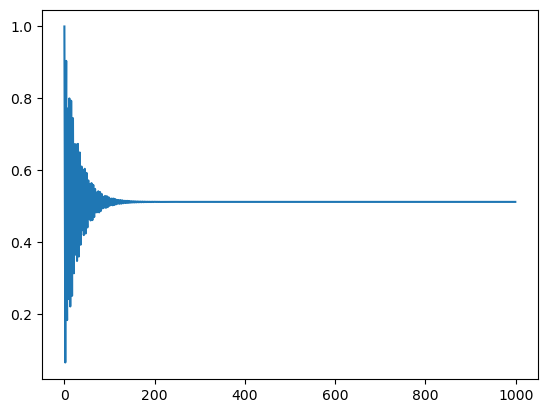

In [82]:
# plot the probabilities as a function of d for different x's
x = np.array([0.1, -3]) 
d = [i for i in range(1000)]
traj = make_prob_series(x, d)
plt.plot(traj[0])
plt.plot(traj[1])
plt.legend(["0", "1"])

(2, 10)


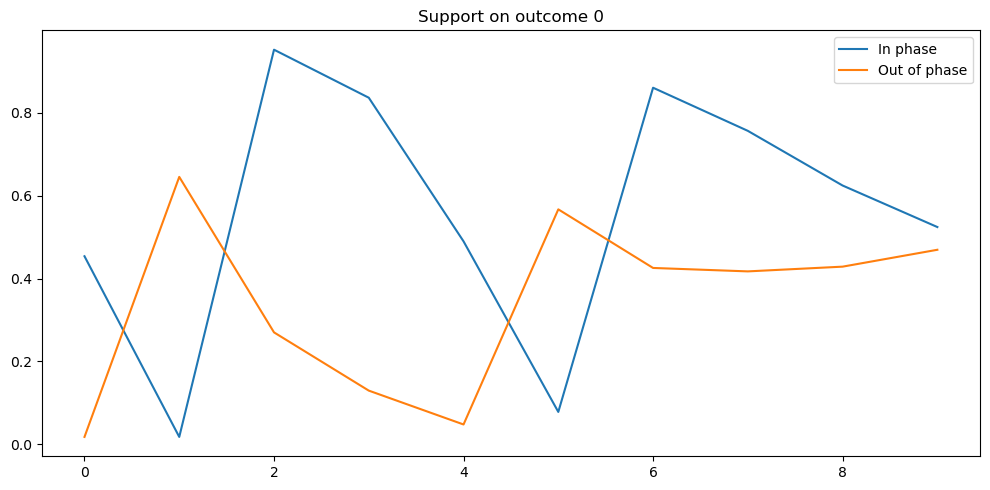

In [83]:
# plot the probabilities as a function of d for different x's
x = np.array([0.1, -5]) 
d = [2**i for i in range(10)]
quad_trajs = make_quadrature_prob_series(x, 10)
plot_quadrature_prob_series_array(quad_trajs)
print(quad_trajs.shape)

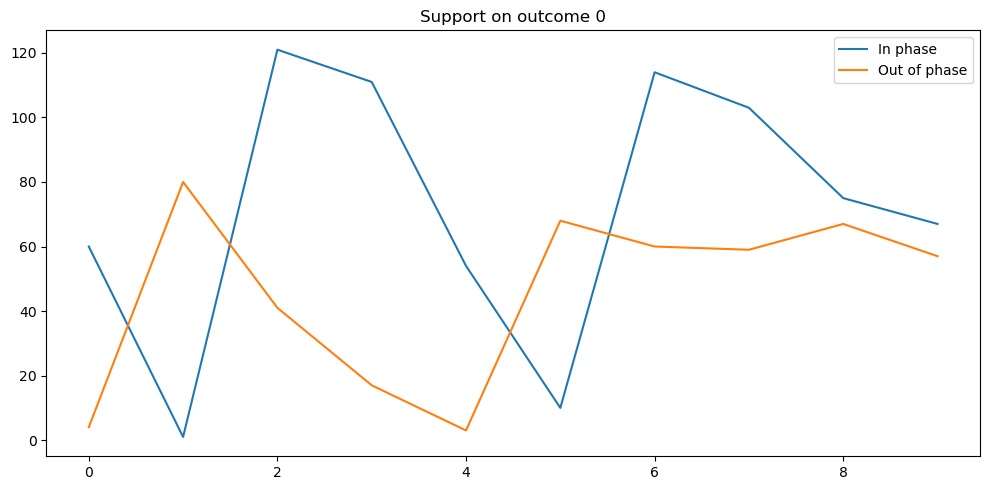

In [84]:
quad_sample_trajs = make_quadrature_sample_series(x, 10, 128)
plot_quadrature_prob_series_array(quad_sample_trajs)


# UKF Definition

The state evolution is 
$$
    x_{k+1} = x_k + w_k
$$
most of the drift in $x$ is due to phase drift, though the decoherence rates can also vary in time. 

The observation model is 
$$
    y_k = h(x_k) + v_k. 
$$
Here, we assume that $y_k$ are emperical probabilities. 


Let us always start the estimator at zero
$$
    \hat{x}_0 = (0, 0, 0). 
$$
The initial state is draw accoridng to a known covariance $P_0$ about zero
$$
    x_0 \sim \mathcal{N}(0, P_0). 
$$
The updates are 
$$
    x_{k+1} = x_k + K_k(y_{k} -\hat{y}_k)
$$
where the updates are made using sigma points. 

In [200]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints, SimplexSigmaPoints, JulierSigmaPoints
from filterpy.kalman import unscented_transform
from copy import deepcopy
from kalman_filters import format_observation
from numpy import dot
from scipy.linalg import block_diag



class LinbladUKF_XOnly(UnscentedKalmanFilter):
    def __init__(self, x, P, max_depth_power, save_history=False, dt=1, hx=None, fx=None, points=None):
        num_params = 2
        self.points = JulierSigmaPoints(num_params, kappa=0)
        y_len = 2*max_depth_power
        super().__init__(num_params, y_len, dt=1, hx=self.hx, fx=self.fx, points=self.points)
        self.x = x
        self.P = P
        self.dt=1

        if save_history:
            self.xhistory = [self.x]
            self.Phistory = [self.P]
            self.store_history = True

        #self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        
        #self.points = SimplexSigmaPoints(num_params, alpha=1)
        
    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, max_depth_power):
        return make_quadrature_prob_series(x, max_depth_power).flatten()

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass
        
    def compute_process_sigmas(self, dt, fx=None, **fx_args):
        """
        computes the values of sigmas_f. Normally a user would not call
        this, but it is useful if you need to call update more than once
        between calls to predict (to update for multiple simultaneous
        measurements), so the sigmas correctly reflect the updated state
        x, P.
        """

        if fx is None:
            fx = self.fx

        # calculate sigma points for given mean and covariance
        sigmas = self.points_fn.sigma_points(self.x, self.P)

        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)

    def predict(self, dt=None, UT=None, fx=None, **fx_args):
        """
        Performs the predict step of the UKF. On return, self.x and
        self.P contain the predicted state (x) and covariance (P). '

        Important: this MUST be called before update() is called for the first
        time.

        Parameters
        ----------

        dt : double, optional
            If specified, the time step to be used for this prediction.
            self._dt is used if this is not provided.

        fx : callable f(x, dt, **fx_args), optional
            State transition function. If not provided, the default
            function passed in during construction will be used.

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        **fx_args : keyword arguments
            optional keyword arguments to be passed into f(x).
        """

        if dt is None:
            dt = self._dt

        if UT is None:
            UT = unscented_transform

        # calculate sigma points for given mean and covariance
        self.compute_process_sigmas(dt, fx, **fx_args)

        #and pass sigmas through the unscented transform to compute prior
        _, self.P = UT(self.sigmas_f, self.Wm, self.Wc, self.Q,
                            self.x_mean, self.residual_x)

        # update sigma points to reflect the new variance of the points
        #self.sigmas_f = self.points_fn.sigma_points(self.x, self.P)
        self.compute_process_sigmas(0, fx, **fx_args)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    def update(self, quadrature_count_series, max_depth_power, num_shots_per_circuit, UT=None, hx=None, data_format="cartesian"):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        observation: emperical distribution

        d: int, depth of the circuit

        num_shots: int, number of shots per circuit

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """
        
        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R
        
        z = quadrature_count_series/num_shots_per_circuit
        #alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts)) Uncomment for Dirichlet covar
        #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
        R = (0.25/num_shots_per_circuit)*np.eye(2*max_depth_power)

        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_h = []
        for s in self.sigmas_f:
            sigmas_h.append(hx(s, max_depth_power))
        self.sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
        self.SI = self.inv(self.S)

        # compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
        
        # DEBUG
        # print(self.sigmas_f, self.sigmas_h)
        # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

        self.K = dot(Pxz, self.SI)        # Kalman gain
        self.y = self.residual_z(z, zp)   # residual

        x_new = self.x + dot(self.K, self.y)
        # phase unwrapping on x[2]
        # x_new[2] = np.unwrap([x_new[2]])
        # if np.linalg.norm(x_new - self.x) < tol:
        #     break
        # else:
        #     self.x = x_new
        #     self.compute_process_sigmas(self.dt, self.fx)
        #     #if i == max_iter - 1:
        #     #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        self.x = x_new
        self.P = self.P - self.K@self.S@self.K.T

        # save measurement and posterior state
        self.x_post = self.x.copy()
        self.z = deepcopy(z)
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        if self.store_history:
            self.xhistory.append(self.x)
            self.Phistory.append(self.P)

    def iterated_update(self, quadrature_count_series, max_depth_power, num_shots_per_circuit, UT=None, hx=None, num_iter=1, stopping_threshold=1e-4):
        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform
        
        z = quadrature_count_series/num_shots_per_circuit
        for i in range(num_iter):
            #alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts)) Uncomment for Dirichlet covar
            #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
            R = (0.25/num_shots_per_circuit)*np.eye(2*max_depth_power)

            # pass prior sigmas through h(x) to get measurement sigmas
            # the shape of sigmas_h will vary if the shape of z varies, so
            # recreate each time
            sigmas_h = []
            for s in self.sigmas_f:
                sigmas_h.append(hx(s, max_depth_power))
            self.sigmas_h = np.atleast_2d(sigmas_h)

            # mean and covariance of prediction passed through unscented transform
            zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
            self.SI = self.inv(self.S)

            # compute cross variance of the state and the measurements
            Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
            
            # DEBUG
            # print(self.sigmas_f, self.sigmas_h)
            # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

            self.K = dot(Pxz, self.SI)        # Kalman gain
            self.y = self.residual_z(z, zp)   # residual

            x_new = self.x + dot(self.K, self.y)
            # phase unwrapping on x[2]
            # x_new[2] = np.unwrap([x_new[2]])
            # if np.linalg.norm(x_new - self.x) < tol:
            #     break
            # else:
            #     self.x = x_new
            #     self.compute_process_sigmas(self.dt, self.fx)
            #     #if i == max_iter - 1:
            #     #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
            if np.linalg.norm(self.y) < stopping_threshold:
                self.x = x_new
                break
            else:
                self.x = x_new
                self.compute_process_sigmas(self.dt, self.fx)
            self.P = self.P - self.K@self.S@self.K.T
            self.predict()

        # save measurement and posterior state
        self.x_post = self.x.copy()
        self.z = deepcopy(z)
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

        if self.store_history:
            self.xhistory.append(self.x)
            self.Phistory.append(self.P)

In [201]:
# make a trajectory and filter
xhat0 = np.array([0, 0])

P0 = np.diag([1e-2, 10])
Q = np.diag([1e-6, 1e-6])

num_shots_per_circuit = 100
num_observations = 10
max_depth_power = 5
ukf = LinbladUKF_XOnly(xhat0, P0, max_depth_power, save_history=True)

In [202]:
xhat0

array([0, 0])

In [203]:
from tqdm import tqdm

In [204]:

ukf.Q = Q

x0 = np.random.multivariate_normal(xhat0, P0)

x_true_history = [x0]
w_history = []

for i in tqdm(range(1, num_observations+1)):
    w = np.random.multivariate_normal(np.zeros(2), Q)
    w_history.append(w)

    x_true = x_true_history[i-1] + w
    x_true_history.append(x_true)

    y = make_quadrature_sample_series(x_true, max_depth_power, num_shots_per_circuit).flatten()
    ukf.predict()
    ukf.update(y, max_depth_power, num_shots_per_circuit)




100%|██████████| 10/10 [00:00<00:00, 60.73it/s]


In [205]:
def plot_traj_comparison(trajs, labels):
    fig, axs = plt.subplots(len(trajs[0]), figsize=(10, 5))
    for i, traj in enumerate(trajs):
        for j, ax in enumerate(axs):
            ax.plot(traj[j], label=labels[i] if labels else None)
    plt.legend()
    plt.show()
x_true_history = np.array(x_true_history)

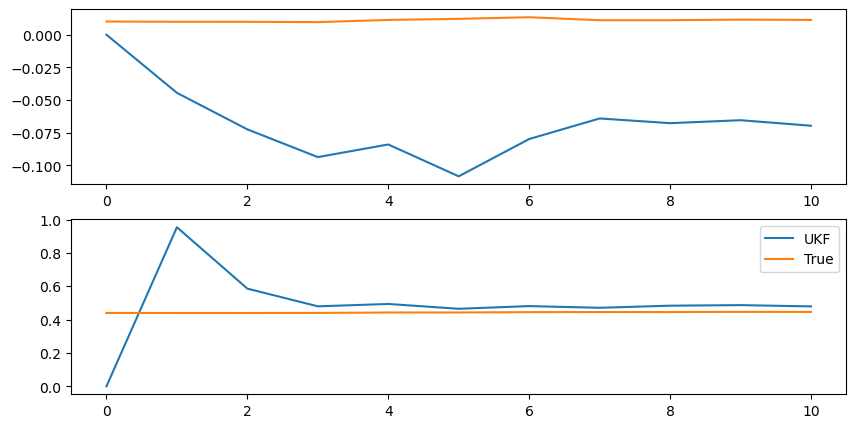

In [206]:
ukf_history = np.array(ukf.xhistory)
plot_traj_comparison([ukf_history.T, x_true_history.T], ["UKF", "True"])

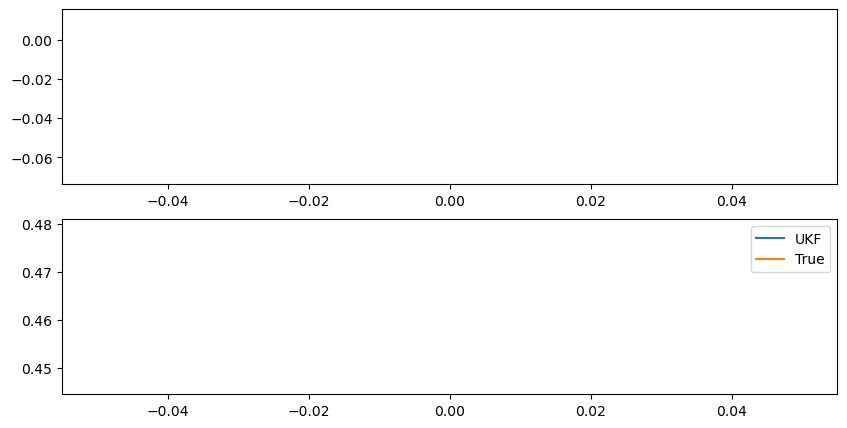

In [207]:
second_start_idx = 10
plot_traj_comparison([ukf_history[second_start_idx:].T, x_true_history[second_start_idx:].T], ["UKF", "True"])

# iterated on single observation

In [247]:
# compare with direct trig inversion estimate
from quapack.pyRPE.quantum import Q as _rpeQ
from quapack.pyRPE.classical import RobustPhaseEstimation

def estimate_1q_phase_from_raw_counts(cos_counts, sin_counts, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        if d == 0:
            continue
        experiment.process_cos(d, (int(cos_counts[0][idx]), int(cos_counts[1][idx])))
        experiment.process_sin(d, (int(sin_counts[0][idx]), int(sin_counts[1][idx])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

def quad_series_to_data_dict(series, max_depth_power, num_shots_per_circuit):
    assert len(series[0]) == max_depth_power
    assert len(series[1]) == max_depth_power
    cos_0_counts = series[0]
    sin_0_counts = series[1]
    cos_1_counts = num_shots_per_circuit - cos_0_counts
    sin_1_counts = num_shots_per_circuit - sin_0_counts
    return {"cos": np.array([cos_0_counts, cos_1_counts]), "sin": np.array([sin_0_counts, sin_1_counts])}

def estimate_trig_phase_from_quad_series(series, max_depth_power, num_shots_per_circuit):
    data_dict = quad_series_to_data_dict(series, max_depth_power, num_shots_per_circuit)
    estimates, lgg =  estimate_1q_phase_from_raw_counts(data_dict["cos"], data_dict["sin"], [2**i for i in range(max_depth_power)])
    estimate = estimates[lgg]
    rectified_estiate = np.pi/2 -  (estimate - np.pi) % (2*np.pi) 
    return rectified_estiate, lgg

In [258]:
max_depth_power = 13
num_shots_per_circuit = 1000

amp_decay_rate = -3

phase_covar = 1e-1
x0 = np.array([np.random.normal(0, phase_covar), amp_decay_rate]) 

quad_series = make_quadrature_sample_series(x0, max_depth_power, num_shots_per_circuit)

In [259]:
xhat_trig, lgg = estimate_trig_phase_from_quad_series(quad_series, max_depth_power, num_shots_per_circuit)
print(x0, xhat_trig, lgg)

[-0.0280413 -3.       ] -0.02342951346890043 6


In [263]:
Q = 1e-12*np.eye(2)
p00 = np.pi/(2*2**lgg)
P0 = np.diag([1e-3, 1e-3])


xhat0 = np.array([xhat_trig, amp_decay_rate])

ukf = LinbladUKF_XOnly(xhat0, P0, max_depth_power, save_history=True)
y0 = quad_series.flatten()

ukf.Q = Q
ukf.predict()
ukf.iterated_update(y0, max_depth_power, num_shots_per_circuit, num_iter=100, stopping_threshold=1e-4)

In [264]:
ukf.x

array([-0.02983952, -3.0894329 ])

In [265]:
x0

array([-0.0280413, -3.       ])

In [266]:
# do it n times

num_trials = 100
max_depth_power = 10
num_shots_per_circuit = 1000

amp_decay_rate = -3
xhat_0 = np.array([0, 0])
P0 = np.diag([1e-2, 1])

x0_history = []
y0_history = []
xhat_kalman_history = []
xhat_trig_history = []

for idx, n in enumerate(tqdm(range(num_trials))):
    x0 = np.array([np.random.normal(0, P0[0,0]), amp_decay_rate]) 
    quad_series = make_quadrature_sample_series(x0, max_depth_power, num_shots_per_circuit)

    ukf = LinbladUKF_XOnly(xhat0, P0, max_depth_power, save_history=True)
    ukf.Q = Q
    ukf.predict()
    ukf.iterated_update(quad_series.flatten(), max_depth_power, num_shots_per_circuit, num_iter=100, stopping_threshold=1e-4)

    trig_estimate, lgg = estimate_trig_phase_from_quad_series(quad_series, max_depth_power, num_shots_per_circuit)

    x0_history.append(x0)
    y0_history.append(quad_series)
    xhat_kalman_history.append(ukf.x)
    xhat_trig_history.append(trig_estimate)
    

100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


In [267]:
kalman_amp_decay = np.array(xhat_kalman_history)[:,1]
print(kalman_amp_decay)

[-2.91909555 -3.00943419 -3.0023162  -2.98812752 -2.92317928 -3.00295062
 -3.08017238 -3.01872318 -3.00773568 -3.06006768 -2.94007575 -2.97150349
 -3.02603209 -3.02907638 -3.03290095 -2.94534403 -3.05779987 -2.98698484
 -3.02369248 -3.02617454 -2.9727232  -3.01051142 -2.99177737 -2.88538072
 -3.01014541 -2.91236485 -2.99709538 -2.96089106 -2.97894036 -3.00508156
 -3.0606367  -3.07402812 -2.95212324 -3.00100864 -2.9922991  -3.01151859
 -2.97868968 -3.06463363 -2.98354917 -3.00707898 -2.99556308 -3.01459804
 -3.00100626 -2.93503552 -2.9810003  -2.98148623 -3.00362204 -3.04539074
 -3.02824785 -3.04257979 -3.03569665 -2.97925768 -3.04279112 -2.99044757
 -3.00651456 -2.97970292 -3.05568802 -3.00169446 -3.00969477 -2.95981231
 -2.99554041 -3.05858233 -2.92490814 -2.92357361 -3.01770851 -3.00626092
 -2.97320711 -3.04775888 -3.05584965 -3.05887196 -2.96280845 -3.04430866
 -3.0222569  -2.94838824 -3.03125773 -3.12782282 -2.92547403 -3.07097652
 -2.94881185 -2.98175919 -2.93931    -3.04681172 -2

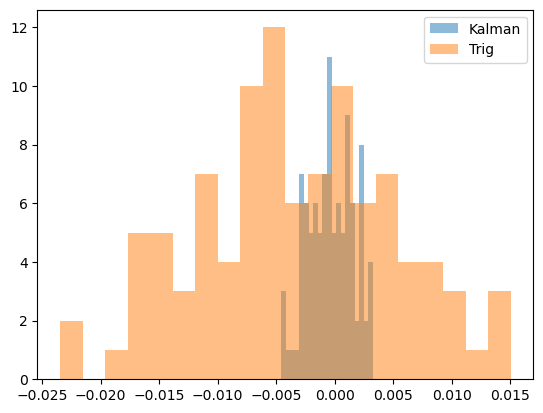

In [268]:
# calculate and plot errors
x0_history = np.array(x0_history)
xhat_kalman_history = np.array(xhat_kalman_history)
xhat_trig_history = np.array(xhat_trig_history)

kalman_errors = xhat_kalman_history[:, 0] - x0_history[:, 0]
trig_errors = xhat_trig_history - x0_history[:, 0]

plt.hist(kalman_errors, bins=20, alpha=0.5, label="Kalman")
plt.hist(trig_errors, bins=20, alpha=0.5, label="Trig")
plt.legend()

In [270]:
np.pi/2**13

0.0003834951969714103

In [58]:
# calculate the errors as a function of the amp decay rate

num_trials = 100
max_depth_power = 10
num_shots_per_circuit = 100
amp_decay_rates = [-6, -5, -4, -3, -2, -1, 0]

histories = {}

for decay_rate in tqdm(amp_decay_rates):
    xhat_0 = np.array([0, decay_rate])
    x0_history = []
    y0_history = []
    xhat_kalman_history = []
    xhat_trig_history = []
    lgg_history = []

    for idx, n in enumerate((range(num_trials))):
        x0 = xhat_0  + np.random.multivariate_normal(np.zeros(2), P0)
        quad_series = make_quadrature_sample_series(x0, max_depth_power, num_shots_per_circuit)

        ukf = LinbladUKF_XOnly(xhat0, P0, max_depth_power, save_history=True)
        ukf.Q = Q
        ukf.predict()
        ukf.iterated_update(quad_series.flatten(), max_depth_power, num_shots_per_circuit, num_iter=100, stopping_threshold=1e-6)

        trig_estimate, lgg = estimate_trig_phase_from_quad_series(quad_series, max_depth_power, num_shots_per_circuit)

        x0_history.append(x0)
        y0_history.append(quad_series)
        xhat_kalman_history.append(ukf.x)
        xhat_trig_history.append(trig_estimate)
        lgg_history.append(lgg)

    history_row = {"x0": x0_history, "y0": y0_history, "xhat_kalman": xhat_kalman_history, "xhat_trig": xhat_trig_history, "lgg": lgg_history}
    histories[decay_rate] = history_row
    

  0%|          | 0/7 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [346]:
# calculate RMSE and plot
kalman_squared_errors = []
trig_squared_errors = []

for decay_rate, history in histories.items():
    x0_history = np.array(history["x0"])
    xhat_kalman_history = np.array(history["xhat_kalman"])
    xhat_trig_history = np.array(history["xhat_trig"])

    kalman_errors = xhat_kalman_history[:, 0] - x0_history[:, 0]
    trig_errors = xhat_trig_history - x0_history[:, 0]

    kalman_squared_errors.append(np.mean(kalman_errors**2))
    trig_squared_errors.append(np.mean(trig_errors**2))

    

Text(0, 0.5, 'RMSE')

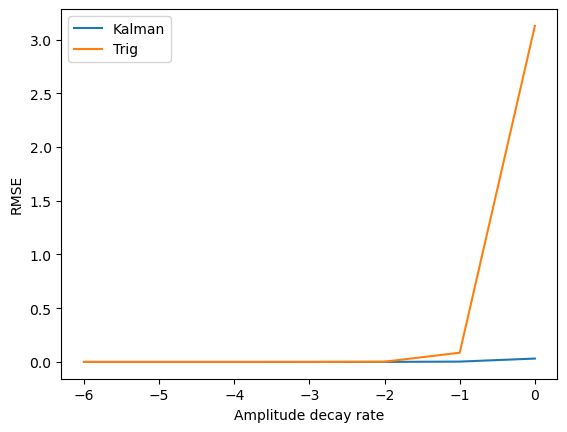

In [351]:
plt.plot(amp_decay_rates, kalman_squared_errors, label="Kalman")
plt.plot(amp_decay_rates, trig_squared_errors, label="Trig")
plt.legend()
plt.xlabel("Amplitude decay rate")
plt.ylabel("RMSE")

In [352]:
lgg_history

[]